In [1]:
# https://github.com/lemonhu/NER-BERT-pytorch/tree/master/data/msra

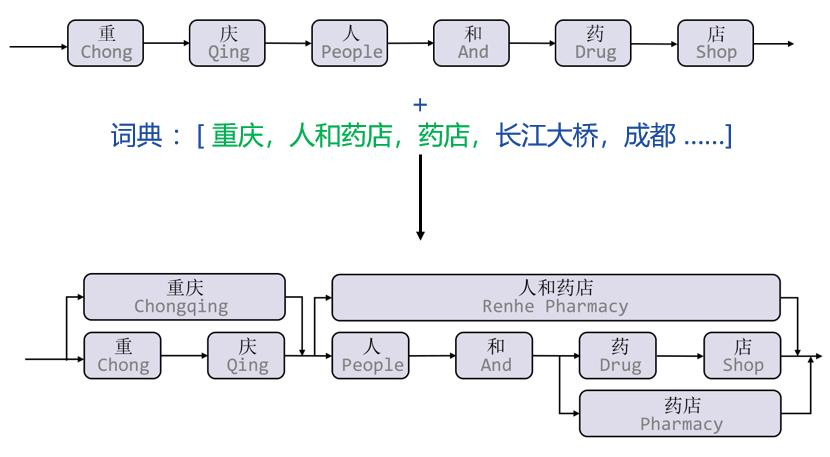

In [1]:
import codecs
import numpy as np

# 我们爱数据科学。
# O O O B-ORG I-ORG I-ORG I-ORG O

In [2]:
tag_type = ['O', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC']
# B-ORG I-ORG 机构的开始位置和中间位置
# B-PER I-PER 人物名字的开始位置和中间位置
# B-LOC I-LOC 位置的开始位置和中间位置

train_lines = codecs.open('msra/train/sentences.txt').readlines()
train_lines = [x.replace(' ', '').strip() for x in train_lines]

train_tags = codecs.open('msra/train/tags.txt').readlines()
train_tags = [x.strip().split(' ') for x in train_tags]
train_tags = [[tag_type.index(x) for x in tag] for tag in train_tags]

In [3]:
train_lines, train_tags = train_lines[:20000], train_tags[:20000] 

In [4]:
val_lines = codecs.open('msra/val/sentences.txt').readlines()
val_lines = [x.replace(' ', '').strip() for x in val_lines]

val_tags = codecs.open('msra/val/tags.txt').readlines()
val_tags = [x.strip().split(' ') for x in val_tags]
val_tags = [[tag_type.index(x) for x in tag] for tag in val_tags]

In [5]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
train_encoding = tokenizer(list(train_lines), truncation=True, padding=True, max_length=64)
val_encoding = tokenizer(list(val_lines), truncation=True, padding=True, max_length=64)

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])[:64] for key, val in self.encodings.items()}
        # 字级别的标注
        item['labels'] = torch.tensor([0] + self.labels[idx] + [0] * (63-len(self.labels[idx])))[:64]
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encoding, train_tags[:])
test_dataset = TextDataset(val_encoding, val_tags[:])

In [7]:
train_dataset[0]

{'input_ids': tensor([ 101, 1963,  862, 6237, 1104, 6639, 4413, 4518, 7270, 3309, 2100, 1762,
         4638, 6436, 1914, 4757, 4688, 8024, 7028, 2920, 3212, 3189, 3823, 7305,
         6639, 4413, 4638, 7413, 7599, 8024, 2768,  711, 1921, 3823, 6639, 1781,
          677,  678, 1079, 1912, 1168, 1905, 6379, 6389, 4638, 6413, 7579,  511,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [8]:
for idx in range(len(train_dataset)):
    item = train_dataset[idx]
    for key in item:
        if item[key].shape[0] != 64:
            print(key, item[key].shape)

In [9]:
for idx in range(len(test_dataset)):
    item = test_dataset[idx]
    for key in item:
        if item[key].shape[0] != 64:
            print(key, item[key].shape)

In [ ]:
import torch
from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
model = BertForTokenClassification.from_pretrained('bert-base-chinese', num_labels=7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 1
scheduler = get_linear_schedule_with_warmup(optim, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-c

NameError: name 'DataLoader' is not defined

In [11]:
from tqdm import tqdm

def train():
    model.train()
    total_train_loss = 0
    iter_num = 0
    total_iter = len(train_loader)
    for idx, batch in enumerate(train_loader):
        optim.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            # loss = outputs[0]

        loss = outputs.loss
        
        if idx % 20 == 0:
            with torch.no_grad():
                # 64 * 7
                print((outputs[1].argmax(2).data == labels.data).float().mean().item(), loss.item())
        
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()
        scheduler.step()

        iter_num += 1
        if(iter_num % 100==0):
            print("epoth: %d, iter_num: %d, loss: %.4f, %.2f%%" % (epoch, iter_num, loss.item(), iter_num/total_iter*100))
        
    print("Epoch: %d, Average training loss: %.4f"%(epoch, total_train_loss/len(train_loader)))
    
def validation():
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in test_dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs[1]

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_eval_accuracy += (outputs[1].argmax(2).data == labels.data).float().mean().item()
        
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    print("Accuracy: %.4f" % (avg_val_accuracy))
    print("Average testing loss: %.4f"%(total_eval_loss/len(test_dataloader)))
    print("-------------------------------")
    

for epoch in range(4):
    print("------------Epoch: %d ----------------" % epoch)
    train()
    validation()

------------Epoch: 0 ----------------
0.2490234375 1.7682684659957886
0.984375 0.08177318423986435
0.9794921875 0.10324091464281082
0.9853515625 0.05329243093729019
0.974609375 0.0980382040143013
epoth: 0, iter_num: 100, loss: 0.0187, 16.00%
0.98486328125 0.03968340530991554
0.97802734375 0.13193301856517792
0.96875 0.09083674848079681
0.99462890625 0.030755499377846718
0.96435546875 0.15113528072834015
epoth: 0, iter_num: 200, loss: 0.0309, 32.00%
0.98046875 0.05407458916306496
0.9755859375 0.04200287163257599
0.96337890625 0.10279929637908936
0.9755859375 0.05761774629354477
0.99560546875 0.027676289901137352
epoth: 0, iter_num: 300, loss: 0.0450, 48.00%
0.99072265625 0.04058162495493889
0.99169921875 0.03472297638654709
0.9833984375 0.0438205860555172
0.9912109375 0.02867487072944641
0.98486328125 0.05152392014861107
epoth: 0, iter_num: 400, loss: 0.0556, 64.00%
0.99267578125 0.020176555961370468
0.9833984375 0.03304135426878929
0.99365234375 0.021856384351849556
0.99609375 0.025094

In [12]:
torch.save(model, 'bert-ner.pt')

In [6]:
tag_type = ['O', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC']

def predcit(s):
    item = tokenizer([s], truncation=True, padding='longest', max_length=64)
    with torch.no_grad():
        input_ids = torch.tensor(item['input_ids']).to(device).reshape(1, -1)
        attention_mask = torch.tensor(item['attention_mask']).to(device).reshape(1, -1)
        labels = torch.tensor([0] * attention_mask.shape[1]).to(device).reshape(1, -1)
        
        outputs = model(input_ids, attention_mask, labels)
        outputs = outputs[0].data.cpu().numpy()
        
    outputs = outputs[0].argmax(1)[1:-1]
    ner_result = ''
    ner_flag = ''
    
    for o, c in zip(outputs,s):
        # 0 就是 O，没有含义
        if o == 0 and ner_result == '':
            continue
        
        # 
        elif o == 0 and ner_result != '':
            if ner_flag == 'O':
                print('机构：', ner_result)
            if ner_flag == 'P':
                print('人名：', ner_result)
            if ner_flag == 'L':
                print('位置：', ner_result)
                
            ner_result = ''
        
        elif o != 0:
            ner_flag = tag_type[o][2]
            ner_result += c
    return outputs

In [7]:
s = '整个华盛顿已笼罩在一片夜色之中，一个电话从美国总统府白宫打到了菲律宾总统府马拉卡南宫。'
# 识别出句子里面的实体识别（NER）
data = predcit(s)

# 标注信息：是对每个字进行标注。
# 标注信息：任务不同标注不同。
#    文本分类：样本 -》 类别，一个句子一个标注
#    实体识别：样本 -》 字级别的类别，一个句子

# 如 何 解 决 足 球 界 长 期 存 在 的 诸 多 矛 盾 ， 重 振 昔 日 津 门 足 球 的 雄 风 ， 成 为 天 津 足 坛 上 下 内 外 到 处 议 论 的 话 题 。
# O O O O O O O O O O O O O O O O O O O O O B-LOC I-LOC O O O O O O O O B-LOC I-LOC O O O O O O O O O O O O O O

位置： 华盛顿
位置： 美国
位置： 白宫
位置： 菲律宾
位置： 马拉卡南宫


In [35]:
s = '人工智能是未来的希望，也是中国和美国的冲突点。'
data = predcit(s)

位置： 中国
位置： 美国


In [37]:
s = '明天我们一起在海淀吃个饭吧，把叫刘涛和王华也叫上。'
data = predcit(s)

位置： 海淀
人名： 刘涛
人名： 王华


In [9]:
s = '同煤集团同生安平煤业公司发生井下安全事故 19名矿工遇难'
data = predcit(s)

机构： 同煤集团同生安平煤业公司


In [10]:
s = '山东省政府办公厅就平邑县玉荣商贸有限公司石膏矿坍塌事故发出通报'
data = predcit(s)

# 实体抽取
# 语义分割是图像

机构： 山东省政府办公厅
机构： 平邑县玉荣商贸有限公司


In [12]:
s = '[新闻直播间]黑龙江:龙煤集团一煤矿发生火灾事故'
data = predcit(s)

位置： 黑龙江
机构： 龙煤集团


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]

vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
X2 = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names())

['and', 'and this', 'document', 'document is', 'first', 'first document', 'is', 'is the', 'is this', 'one', 'second', 'second document', 'the', 'the first', 'the second', 'the third', 'third', 'third one', 'this', 'this document', 'this is', 'this the']


In [5]:
X2

<4x22 sparse matrix of type '<class 'numpy.longlong'>'
	with 39 stored elements in Compressed Sparse Row format>

In [ ]:
CountVectorizer + TfidfTransformer = TfidfVectorizer
TfidfVectorizer：直接输入文本